In [1]:
import torch

torch.set_default_dtype(torch.float32)
torch.manual_seed(91021)
torch.__version__

'2.2.1+cu121'

# Synthetic Data

In [2]:
# create known parameters
weight = 0.7
bias = 0.3

# create data
X = torch.arange(0, 1, 0.002).unsqueeze(1)
# add normal noise with variance 0.1
y = weight * X + bias + (0.001**0.5) * torch.randn(X.shape)

# train/test splits
split = int(0.8 * len(X))
idx = torch.randperm(len(X))

X_train, y_train = X[idx[:split]], y[idx[:split]]
X_test, y_test = X[idx[split:]], y[idx[split:]]

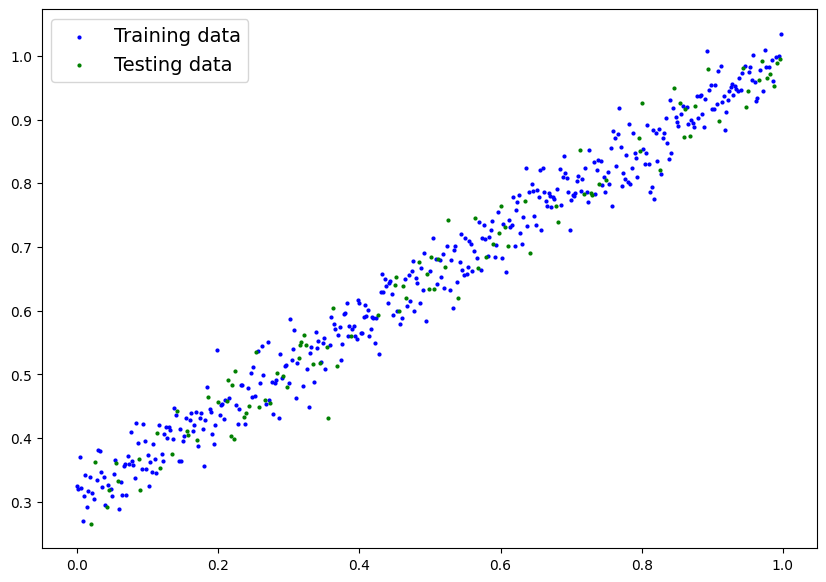

In [3]:
import matplotlib.pyplot as plt


def plot_predictions(
    train_data=X_train,
    train_labels=y_train,
    test_data=X_test,
    test_labels=y_test,
    predictions=None,
):
    """
    Plots training data, test data and compares predictions.
    """
    plt.figure(figsize=(10, 7))

    # Plot training data in blue
    plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")

    # Plot test data in green
    plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")

    if predictions is not None:
        # Plot the predictions in red (predictions were made on the test data)
        plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")

    # Show the legend
    plt.legend(prop={"size": 14})


plot_predictions()

# Model

In [4]:
from torch import nn


class LinearRegression(nn.Module):
    def __init__(self):
        super().__init__()
        self.weight = nn.Parameter(torch.randn(1), requires_grad=True)
        self.bias = nn.Parameter(torch.randn(1), requires_grad=True)

    def forward(self, X: torch.Tensor) -> torch.Tensor:
        return X * self.weight + self.bias

In [5]:
model_0 = LinearRegression()
list(model_0.parameters())

[Parameter containing:
 tensor([0.3014], requires_grad=True),
 Parameter containing:
 tensor([0.6171], requires_grad=True)]

In [6]:
model_0.state_dict()

OrderedDict([('weight', tensor([0.3014])), ('bias', tensor([0.6171]))])

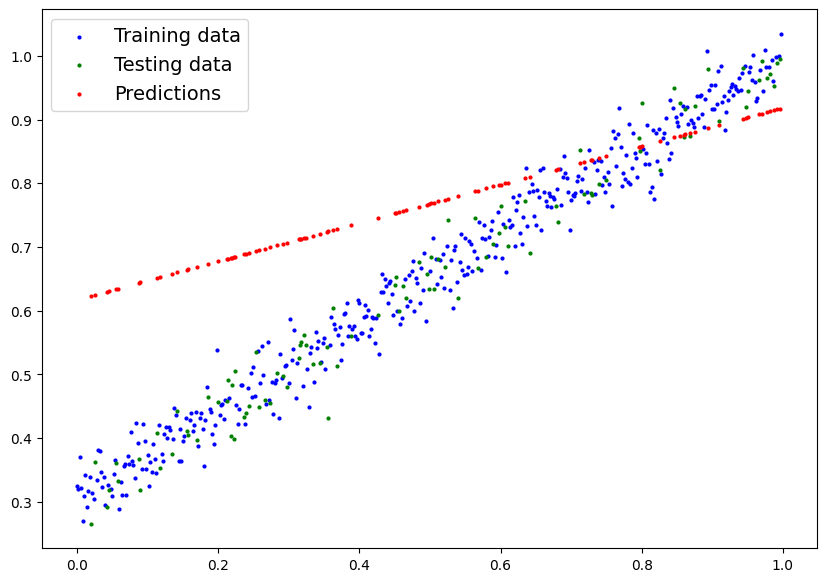

In [7]:
# make predictions
with torch.inference_mode():
    y_preds = model_0(X_test)

plot_predictions(predictions=y_preds)

# Train

In [8]:
from tqdm import tqdm

torch.manual_seed(91021)


def train(X_train, y_train, X_test, y_test):
    # train parameters
    ## learning rate and optimizer
    loss_fn = nn.L1Loss()
    optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.01)
    epochs = 300

    track_epochs = []
    train_loss_values = []
    test_loss_values = []

    for epoch in tqdm(range(epochs), desc="epochs"):
        ## training
        model_0.train()
        y_preds = model_0(X_train)
        loss = loss_fn(y_preds, y_train)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        ## testing
        model_0.eval()
        with torch.inference_mode():
            test_preds = model_0(X_test)
            test_loss = loss_fn(test_preds, y_test.type(torch.float))

            if epoch % 10 == 0:
                track_epochs.append(epoch)
                train_loss_values.append(loss.detach().numpy())
                test_loss_values.append(test_loss.detach().numpy())
                print(
                    f"Epoch: {epoch} | MAE Train Loss: {loss} | MAE Test Loss: {test_loss} "
                )

    # Plot the loss curves
    plt.plot(track_epochs, train_loss_values, label="Train loss")
    plt.plot(track_epochs, test_loss_values, label="Test loss")
    plt.title("Training and test loss curves")
    plt.ylabel("Loss")
    plt.xlabel("Epochs")
    plt.legend()

epochs: 100%|██████████| 300/300 [00:00<00:00, 3245.74it/s]


Epoch: 0 | MAE Train Loss: 0.133229598402977 | MAE Test Loss: 0.14107055962085724 
Epoch: 10 | MAE Train Loss: 0.11099937558174133 | MAE Test Loss: 0.11842422187328339 
Epoch: 20 | MAE Train Loss: 0.1036032885313034 | MAE Test Loss: 0.10948478430509567 
Epoch: 30 | MAE Train Loss: 0.0982377752661705 | MAE Test Loss: 0.1028590127825737 
Epoch: 40 | MAE Train Loss: 0.09351325035095215 | MAE Test Loss: 0.09746963530778885 
Epoch: 50 | MAE Train Loss: 0.08892671763896942 | MAE Test Loss: 0.09246471524238586 
Epoch: 60 | MAE Train Loss: 0.08437824994325638 | MAE Test Loss: 0.08761822432279587 
Epoch: 70 | MAE Train Loss: 0.07988405972719193 | MAE Test Loss: 0.08295486122369766 
Epoch: 80 | MAE Train Loss: 0.07546732574701309 | MAE Test Loss: 0.07838919013738632 
Epoch: 90 | MAE Train Loss: 0.07107488065958023 | MAE Test Loss: 0.07393468171358109 
Epoch: 100 | MAE Train Loss: 0.06677744537591934 | MAE Test Loss: 0.06960592418909073 
Epoch: 110 | MAE Train Loss: 0.06261147558689117 | MAE Test

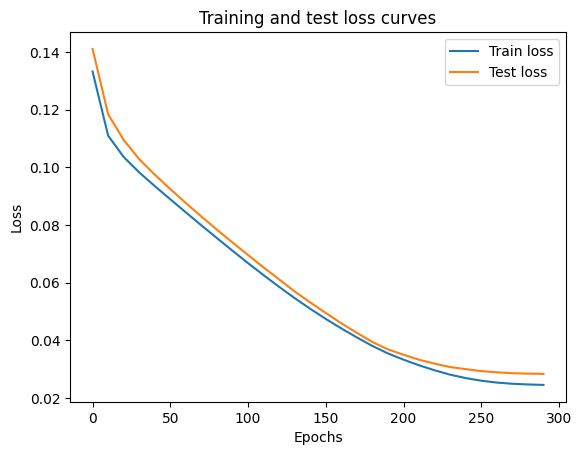

In [9]:
train(X_train, y_train, X_test, y_test)

In [10]:
# Find our model's learned parameters
print("The model learned the following values for weights and bias:")
print(model_0.state_dict())
print("\nAnd the original values for weights and bias are:")
print(f"weights: {weight}, bias: {bias}")

The model learned the following values for weights and bias:
OrderedDict([('weight', tensor([0.6778])), ('bias', tensor([0.3136]))])

And the original values for weights and bias are:
weights: 0.7, bias: 0.3


# Inference

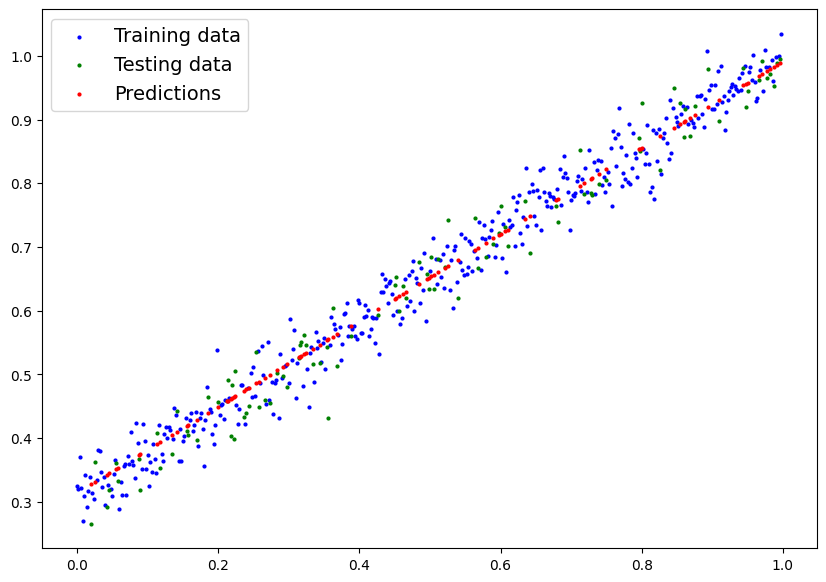

In [11]:
model_0.eval()
with torch.inference_mode():
    y_preds = model_0(X_test)

plot_predictions(predictions=y_preds)

# Saving it

In [12]:
from pathlib import Path

MODEL_PATH = Path("ignore_models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

MODEL_NAME = "01_pytorch_workflow_model_0.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_0.state_dict(), f=MODEL_SAVE_PATH)

Saving model to: ignore_models/01_pytorch_workflow_model_0.pth


In [13]:
# Instantiate a new instance of our model (this will be instantiated with random weights)
loaded_model_0 = LinearRegression()

# Load the state_dict of our saved model (this will update the new instance of our model with trained weights)
loaded_model_0.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

<All keys matched successfully>

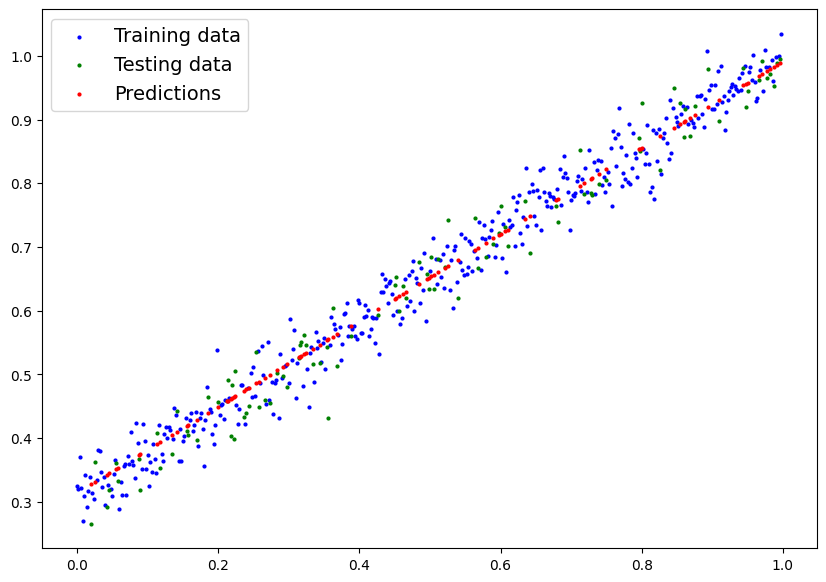

In [14]:
loaded_model_0.eval()

with torch.inference_mode():
    loaded_model_preds = loaded_model_0(X_test)

plot_predictions(predictions=loaded_model_preds)

# Exercises

In [1]:
import torch

torch.set_default_dtype(torch.float32)
torch.manual_seed(91021)
torch.__version__

'2.2.1+cu121'

In [2]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"using device: {DEVICE}")

using device: cpu


### 1. Create a straight line dataset using the linear regression formula (weight * X + bias).
- Set weight=0.3 and bias=0.9 there should be at least 100 datapoints total.
- Split the data into 80% training, 20% testing.
- Plot the training and testing data so it becomes visual.

In [3]:
weight = 0.3
bias = 0.9
points = 100
start = 0
end = 10

X = torch.arange(start, end, (end - start) / points).unsqueeze(1)
y = weight * X + bias

split = int(0.8 * len(X))
idx = torch.randperm(len(X))

X_train, y_train = X[idx[:split]], y[idx[:split]]
X_test, y_test = X[idx[split:]], y[idx[split:]]

In [4]:
from pydantic import BaseModel, ConfigDict


class Data(BaseModel):
    X_train: torch.Tensor = X_train
    y_train: torch.Tensor = y_train
    X_test: torch.Tensor = X_test
    y_test: torch.Tensor = y_test

    model_config = ConfigDict(arbitrary_types_allowed=True)


data = Data()

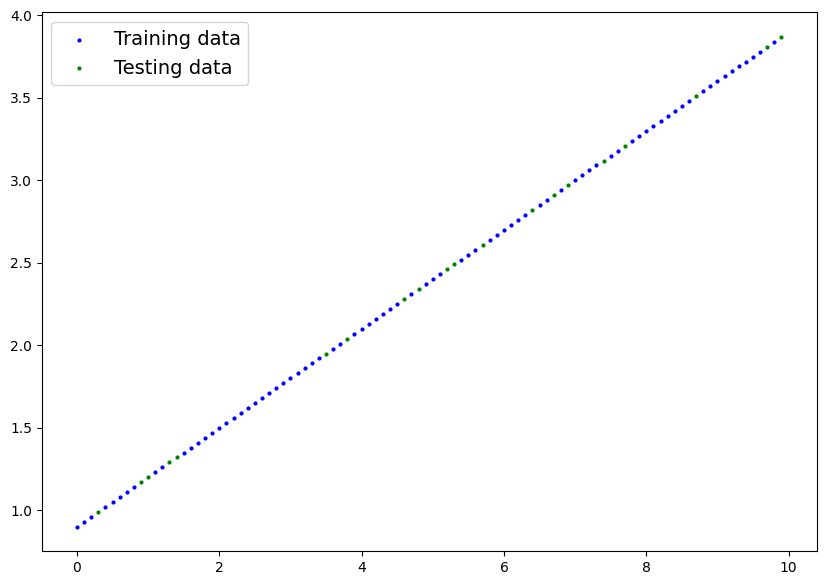

In [6]:
def plot_predictions(
    train_data=X_train,
    train_labels=y_train,
    test_data=X_test,
    test_labels=y_test,
    predictions=None,
):
    """
    Plots training data, test data and compares predictions.
    """
    plt.figure(figsize=(10, 7))

    # Plot training data in blue
    plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")

    # Plot test data in green
    plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")

    if predictions is not None:
        # Plot the predictions in red (predictions were made on the test data)
        plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")

    # Show the legend
    plt.legend(prop={"size": 14})


plot_predictions()

### 2. Build a PyTorch model by subclassing nn.Module.
- Inside should be a randomly initialized nn.Parameter() with requires_grad=True, one for weights and one for bias.
- Implement the forward() method to compute the linear regression function you used to create the dataset in 1.
- Once you've constructed the model, make an instance of it and check its state_dict().
- Note: If you'd like to use nn.Linear() instead of nn.Parameter() you can.

In [7]:
from torch import nn


class CustomLinearRegression(nn.Module):
    def __init__(self, input_dims, output_dims):
        super().__init__()
        self.linear = nn.Linear(in_features=input_dims, out_features=output_dims)

    def forward(self, x: torch.Tensor):
        return self.linear(x)

In [8]:
model = CustomLinearRegression(1, 1)
list(model.parameters()), model.state_dict

([Parameter containing:
  tensor([[0.9940]], requires_grad=True),
  Parameter containing:
  tensor([-0.6558], requires_grad=True)],
 <bound method Module.state_dict of CustomLinearRegression(
   (linear): Linear(in_features=1, out_features=1, bias=True)
 )>)

### 3. Create a loss function and optimizer using nn.L1Loss() and torch.optim.SGD(params, lr) respectively.
- Set the learning rate of the optimizer to be 0.01 and the parameters to optimize should be the model parameters from the model you created in 2.
- Write a training loop to perform the appropriate training steps for 300 epochs.
- The training loop should test the model on the test dataset every 20 epochs.

In [9]:
lr = 0.01
epochs = 300


def train(
    model: nn.Module,
    data: Data,
    loss_fn,
    optimizer,
    epochs: int = epochs,
    device=DEVICE,
):
    X_train = data.X_train.to(device)
    y_train = data.y_train.to(device)
    X_test = data.X_test.to(device)
    y_test = data.y_test.to(device)

    model.to(device)

    for epoch in range(epochs + 1):
        model.train()
        # forward pass
        y_pred = model(X_train)
        # loss
        loss = loss_fn(y_pred, y_train)
        # zero grad
        optimizer.zero_grad()
        # backward propagation
        loss.backward()
        # step
        optimizer.step()

        if epoch % 20 == 0:
            model.eval()
            with torch.inference_mode():
                y_preds = model(X_test)
                test_loss = loss_fn(y_preds, y_test)
                print(
                    f"Epoch: {epoch} | Train loss: {loss:.3f} | Test loss: {test_loss:.3f}"
                )

In [10]:
optimizer = torch.optim.SGD(
    lr=lr,
    params=model.parameters(),
)

loss_fn = nn.L1Loss()
train(model, data, loss_fn, optimizer)

Epoch: 0 | Train loss: 2.207 | Test loss: 2.189
Epoch: 20 | Train loss: 0.659 | Test loss: 0.621
Epoch: 40 | Train loss: 0.624 | Test loss: 0.588
Epoch: 60 | Train loss: 0.589 | Test loss: 0.555
Epoch: 80 | Train loss: 0.554 | Test loss: 0.522
Epoch: 100 | Train loss: 0.519 | Test loss: 0.489
Epoch: 120 | Train loss: 0.484 | Test loss: 0.456
Epoch: 140 | Train loss: 0.449 | Test loss: 0.422
Epoch: 160 | Train loss: 0.414 | Test loss: 0.389
Epoch: 180 | Train loss: 0.379 | Test loss: 0.358
Epoch: 200 | Train loss: 0.345 | Test loss: 0.324
Epoch: 220 | Train loss: 0.310 | Test loss: 0.291
Epoch: 240 | Train loss: 0.275 | Test loss: 0.258
Epoch: 260 | Train loss: 0.240 | Test loss: 0.225
Epoch: 280 | Train loss: 0.205 | Test loss: 0.192
Epoch: 300 | Train loss: 0.170 | Test loss: 0.158


### 4. Make predictions with the trained model on the test data.
- Visualize these predictions against the original training and testing data (note: you may need to make sure the predictions are not on the GPU if you want to use non-CUDA-enabled libraries such as matplotlib to plot).

In [11]:
model.to(DEVICE)
model.eval()
with torch.inference_mode():
    y_preds = model(X_test)

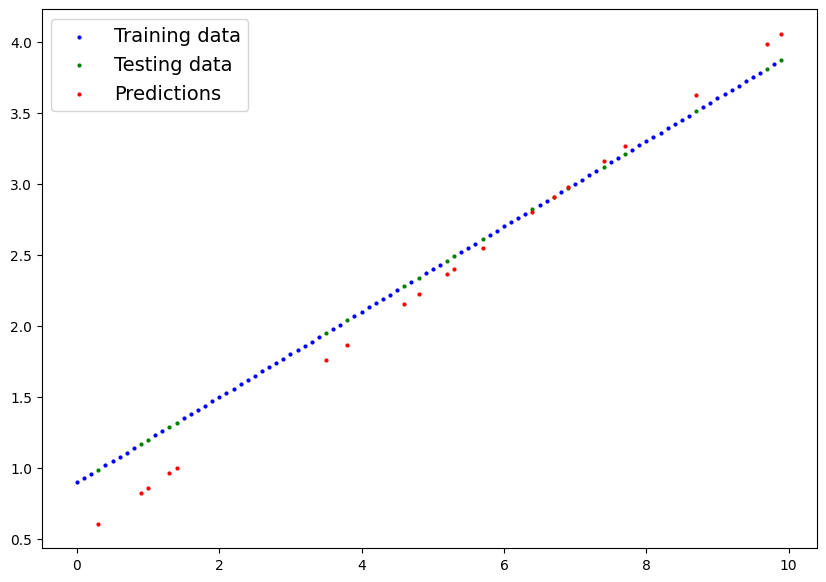

In [ ]:
plot_predictions(predictions=y_preds.cpu())

### 5. Save your trained model's state_dict() to file.
- Create a new instance of your model class you made in 2. and load in the state_dict() you just saved to it.
- Perform predictions on your test data with the loaded model and confirm they match the original model predictions from 4.

In [15]:
from pathlib import Path

MODEL_PATH = Path("ignore_models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

MODEL_NAME = "01_pytorch_workflow_model_exercise.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model.state_dict(), f=MODEL_SAVE_PATH)

Saving model to: ignore_models/01_pytorch_workflow_model_exercise.pth


In [16]:
loaded = CustomLinearRegression(1, 1)

In [17]:
loaded.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

<All keys matched successfully>

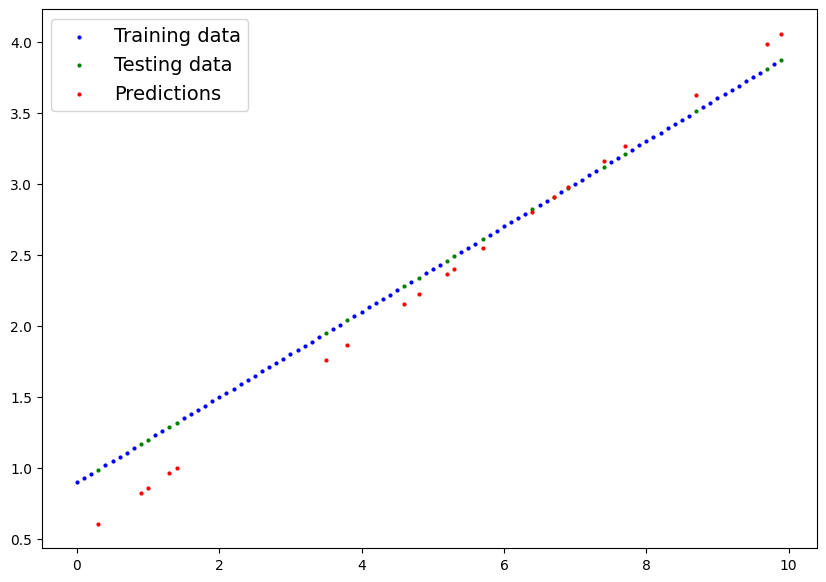

In [18]:
loaded.eval()

with torch.inference_mode():
    loaded_model_preds = loaded(X_test)

plot_predictions(predictions=loaded_model_preds)